In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import classification_report, roc_auc_score

import uproot 
import awkward as ak


In [2]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22
plt.rcParams['axes.facecolor'] = 'white'

In [3]:
file = "/home/dejavu/Projects/Samples/qgcal/merged_hist_weight.root"
merged_file = uproot.open(file)

In [4]:
branch_names = ["total_weight", "pu_weight", "mconly_weight", "jet_fire", "jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID"]
branches = merged_file["nominal"].arrays(branch_names)

## Event trigger and leadjing jets selection

In [5]:
print("Before applying event trigger:")
print(branches.type)

Before applying event trigger:
148462568 * {"total_weight": float32, "pu_weight": float32, "mconly_weight": float32, "jet_fire": bool, "jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}


In [6]:
event_trigger_idx = branches["jet_fire"] == 1
branches = branches[event_trigger_idx]

In [7]:
print("after applying event trigger:")
print(branches.type)

after applying event trigger:
70890262 * {"total_weight": float32, "pu_weight": float32, "mconly_weight": float32, "jet_fire": bool, "jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}


In [12]:
# pT cut 
pt_cut_idx = branches["jet_pt"][:,1] > 500000
branches = branches[pt_cut_idx]

In [13]:
print("after applying pt cut:")
print(branches.type)

after applying pt cut:
36445718 * {"total_weight": float32, "pu_weight": float32, "mconly_weight": float32, "jet_fire": bool, "jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}


In [14]:
# Get the total_weigt information
total_weight = branches["total_weight"]

# select all the jets from all the events 
dijet_properties = branches[branch_names[4:]][:,:2]

In [15]:
# flatten jet
dijet_sample = ak.to_pandas(dijet_properties)

In [16]:
dijet_sample.head()

jet_pt   jet_eta  jet_nTracks  jet_trackWidth  \
entry subentry                                                        
0     0         2.506848e+06 -0.306908          5.0        0.017355   
      1         2.363458e+06  0.679327          9.0        0.010453   
1     0         6.906167e+05 -0.425991         27.0        0.126707   
      1         6.228642e+05  0.157243          8.0        0.005913   
2     0         2.429348e+06 -0.306191          5.0        0.016879   

                jet_trackC1  jet_trackBDT  jet_PartonTruthLabelID  
entry subentry                                                     
0     0            0.089904     -0.555102                      -1  
      1            0.115009     -0.577997                      -1  
1     0            0.243161      0.048448                      -1  
      1            0.144498     -0.522744                      21  
2     0            0.042909     -0.559504                      -1

In [17]:
# repeat the weight to match the first two jets
total_weight_jets = np.repeat(total_weight, 2)
total_weight_jets = total_weight_jets.to_numpy()

In [18]:
dijets = np.hstack((dijet_sample, total_weight_jets[:, None]))

In [19]:
dijets.shape

(72891436, 8)

In [20]:
np.save("dijets_500GeV_weightcut.npy", dijets)

## Draw Components

In [21]:
def draw_components(labels):
    components = np.bincount(labels.astype(int)+1)
    partonID = ['others', 'd', 'u', 's', 'c', 'b', 'gluon']
    plt.bar(partonID, components[components.nonzero()])
    plt.xlabel('Jet Category')
    plt.ylabel('Number of jets')
    plt.text(4, 0.5, f"num. of jets: {len(labels)} ")
    plt.savefig("jet_components")

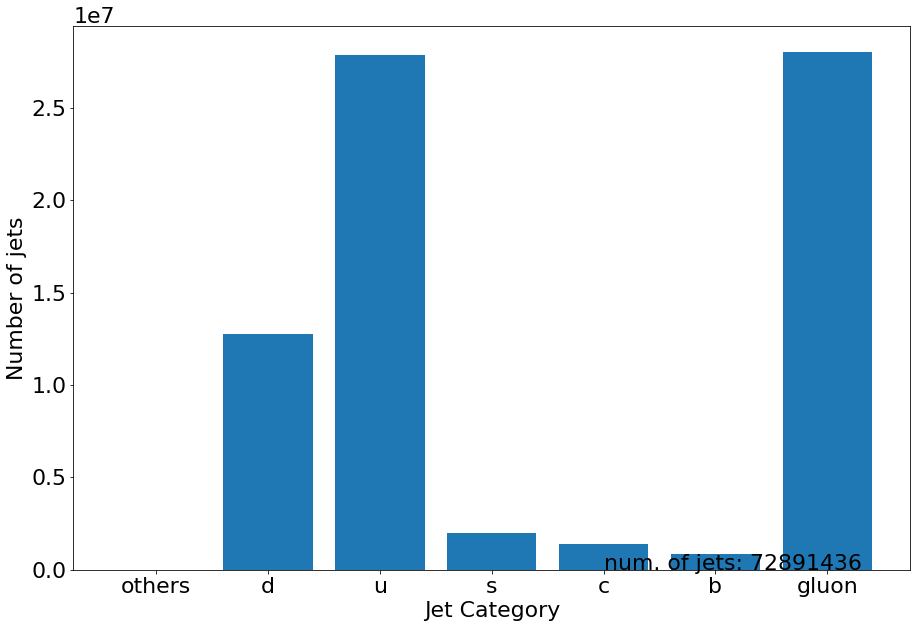

In [23]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22
draw_components(dijets[:,-2])

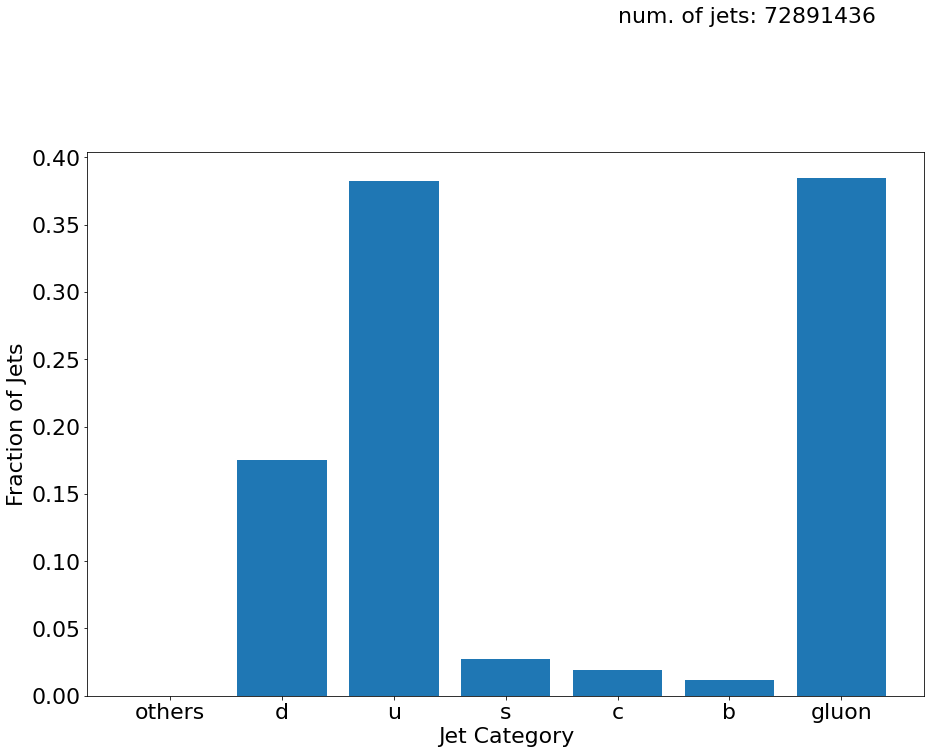

In [24]:
def draw_components_norm(labels):
    components = np.bincount(labels.astype(int)+1)
    partonID = ['others', 'd', 'u', 's', 'c', 'b', 'gluon']
    plt.bar(partonID, components[components.nonzero()]/len(labels))
    plt.xlabel('Jet Category')
    plt.ylabel('Fraction of Jets')
    plt.text(4, 0.5, f"num. of jets: {len(labels)} ")
    plt.savefig("jet_components_norm")
    # plt.show()
draw_components_norm(dijets[:,-2])

In [26]:
user_range = [(20, 2000), (-3, 3), (0, 100), (-0.1, 0.4), (-0.1, 0.5), (-1.0, 1.0)]
user_xlabel = ["Jet $p_{\mathrm{T}}$ [GeV]", "$\eta$", "Number of tracks", "$W_{jet}$", "$C_1$", "BDT Score"]
user_filename = ["dis_jetpt", "dis_eta", "dis_ntracks", "dis_width", "dis_c1", "dis_bdt"]
user_scale = [1e3, 1, 1, 1, 1, 1]

In [27]:
def draw_distribution(variable, range=(0, 100), n_bins=100, weight = 1.0, xlabel='xlabel', ylabel='Number of jets', save = False, fig_name='figure', scale =1.0):
    fig, ax = plt.subplots()
    bins = np.linspace(range[0], range[1], n_bins)
    ax.hist(variable/scale, bins, weights = weight, alpha=0.5, color = 'blue')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if save:
        fig.savefig(fig_name, transparent=False)
    else:
        fig.show()
    

Drawing jet_pt


/tmp/ipykernel_197350/2975779494.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Drawing jet_eta
Drawing jet_nTracks
Drawing jet_trackWidth
Drawing jet_trackC1
Drawing jet_trackBDT


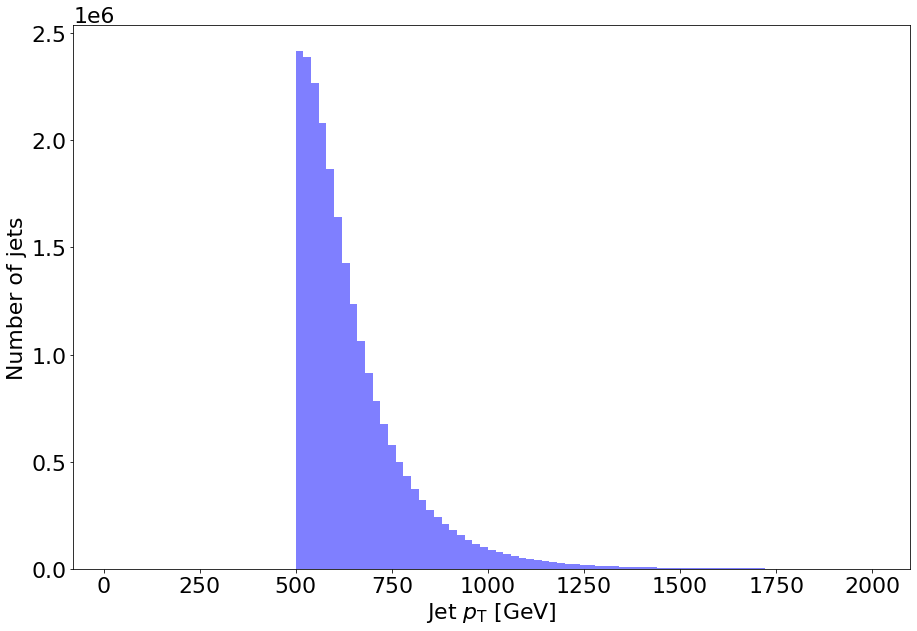

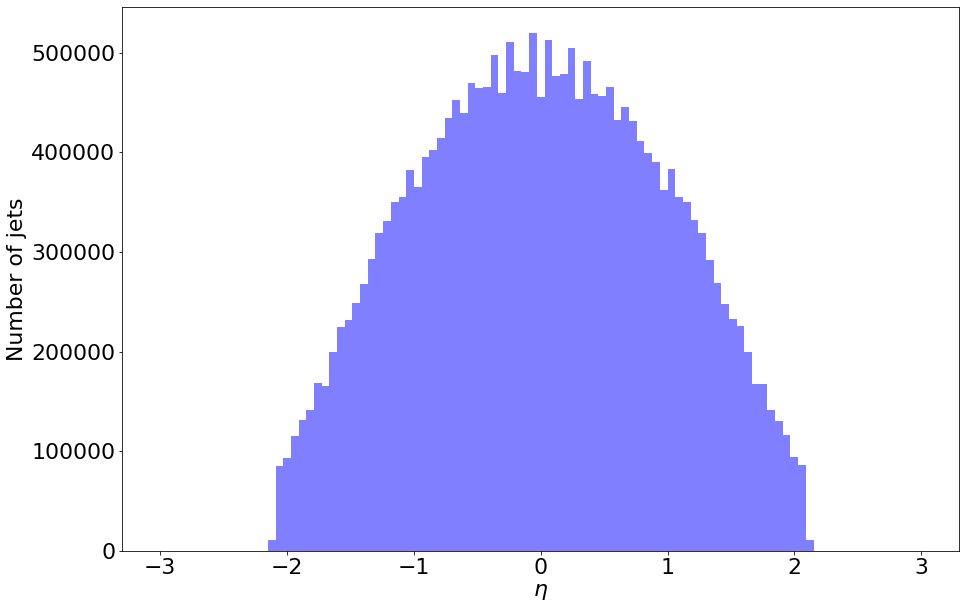

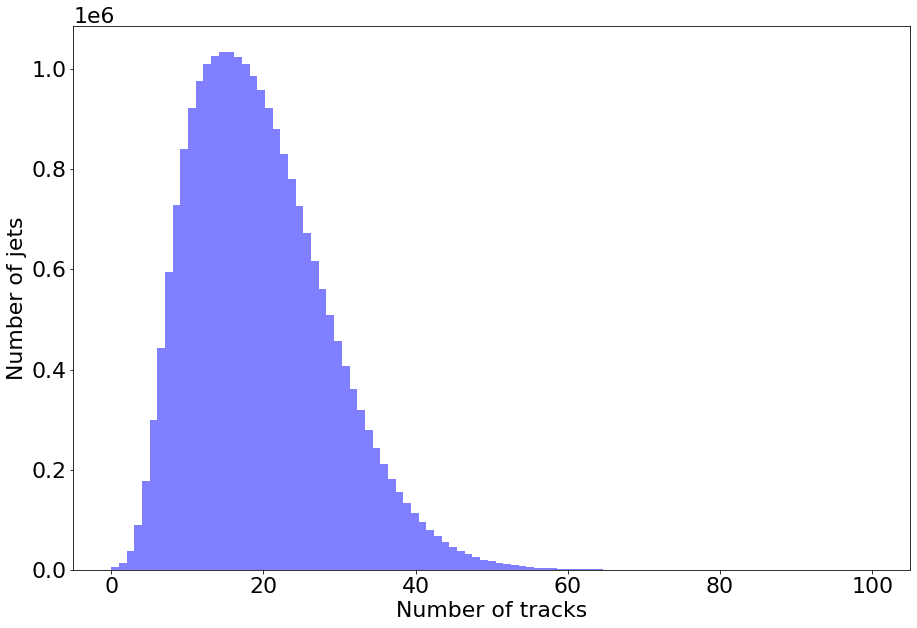

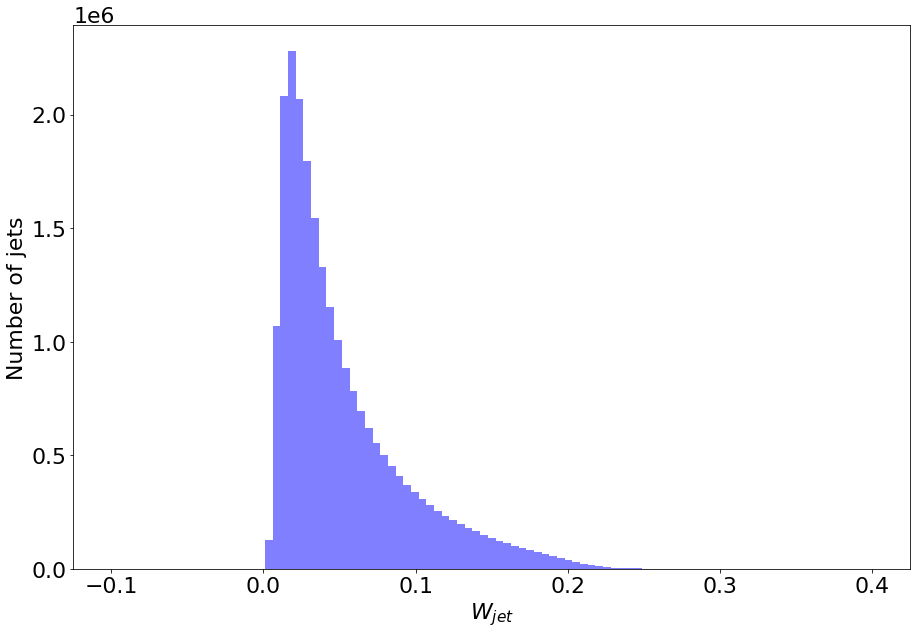

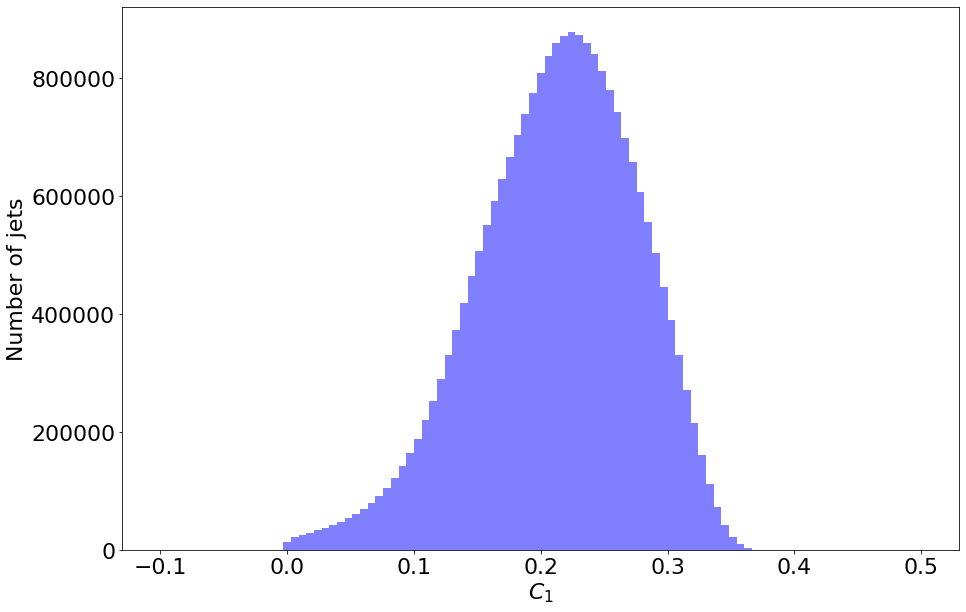

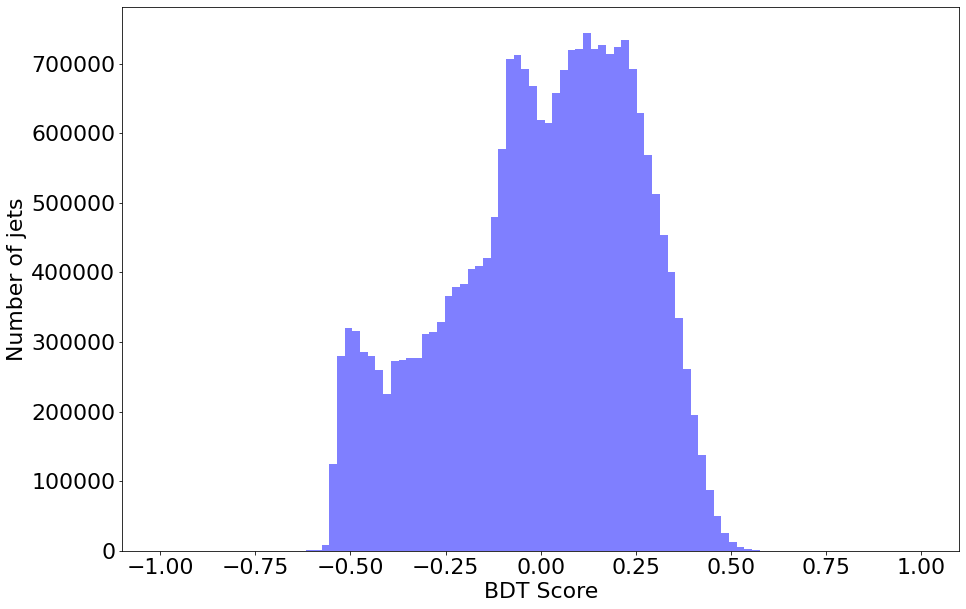

In [29]:
for i in range(0,6):
    print(f"Drawing {branch_names[4+i]}")
    draw_distribution(dijets[:,i], scale=user_scale[i], range=user_range[i], weight=dijets[:,-1], xlabel=user_xlabel[i], save = False, fig_name=user_filename[i]+"_weight_cut")

## Quark vs Gluon
For the following we are always using the weights after weight 100 cut.

In [30]:
gluon_idx = np.where(dijets[:,-2]==21)
light_quark_idx = np.where((dijets[:,-2]==0) | (dijets[:,-2]==1)| (dijets[:,-2]==2))

In [31]:
print(f"Number of gluons: {len(gluon_idx[0])}")
print(f"Number of light quarks: {len(light_quark_idx[0])}")

Number of gluons: 28030113
Number of light quarks: 40603990


In [32]:
gluon = dijets[gluon_idx]
quark = dijets[light_quark_idx]

In [33]:
def draw_distribution_signal_bkg(
    variable_gluon, variable_quark, weight_gluon, weight_quark, 
    range=(0, 100), n_bins=100, density = False, 
    xlabel='xlabel', ylabel='Number of jets', save = False, 
    fig_name='figure', scale =1.0
    ):
    bins = np.linspace(range[0], range[1], n_bins)
    plt.hist(variable_gluon/scale, bins, weights = weight_gluon, density = density, alpha=0.5, label='gluon', color = 'blue')
    plt.hist(variable_quark/scale, bins, weights = weight_quark, density = density, alpha=0.5, label='quark', color = 'red')
    plt.legend(loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save:
        if density:
            plt.savefig(fig_name+"_q_vs_g_norm")
        else:
            plt.savefig(fig_name+"_q_vs_g")
        plt.show()
    else:
        plt.show()
    

### Variables with Normalization

Drawing jet_pt


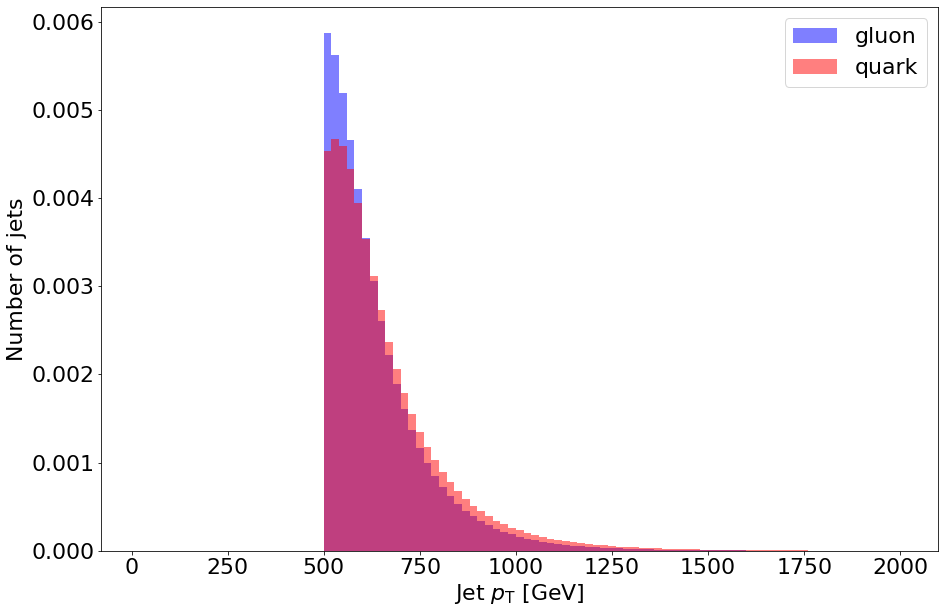

Drawing jet_eta


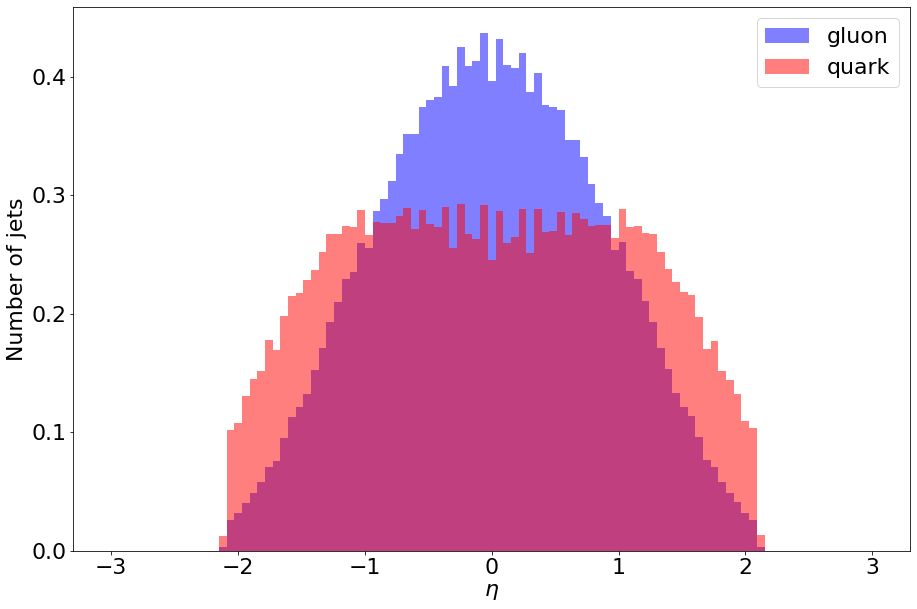

Drawing jet_nTracks


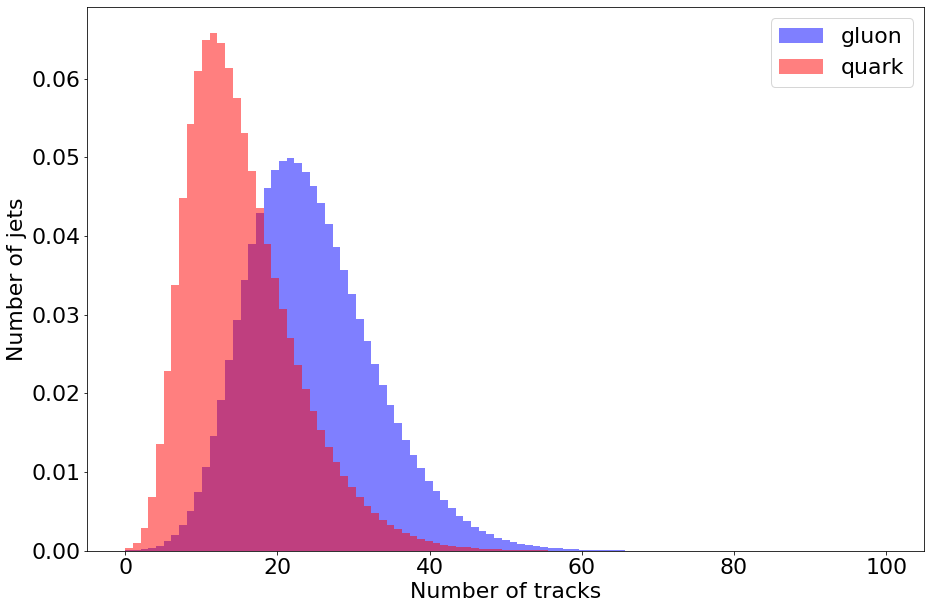

Drawing jet_trackWidth


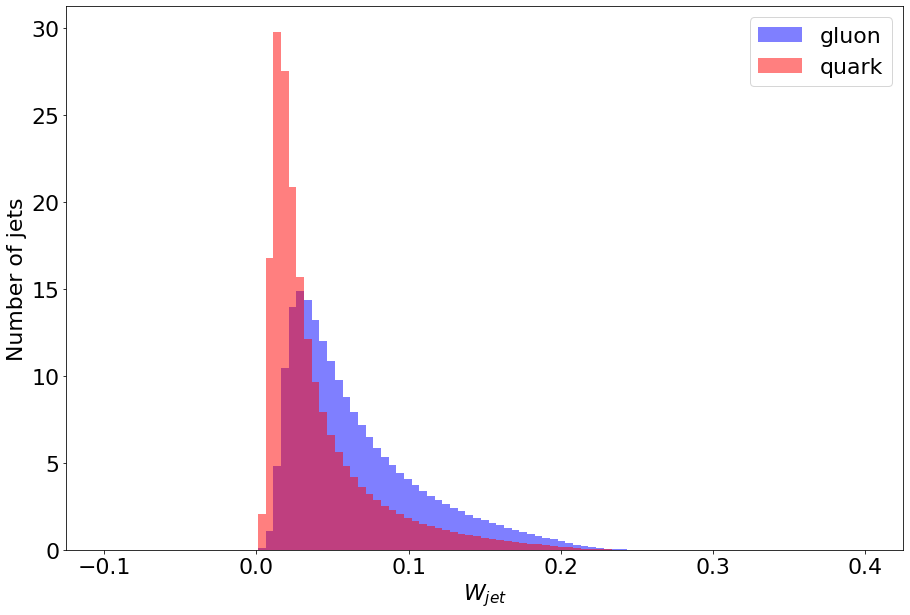

Drawing jet_trackC1


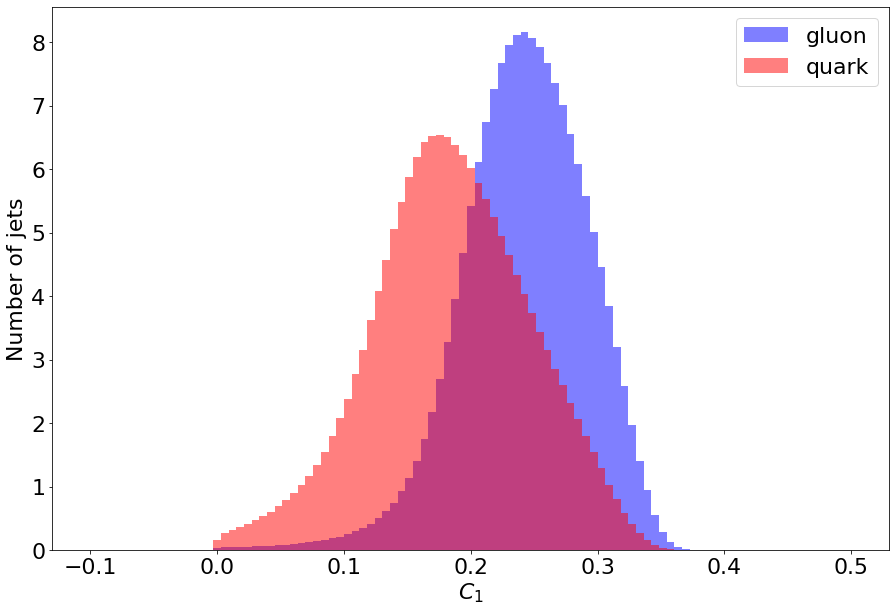

Drawing jet_trackBDT


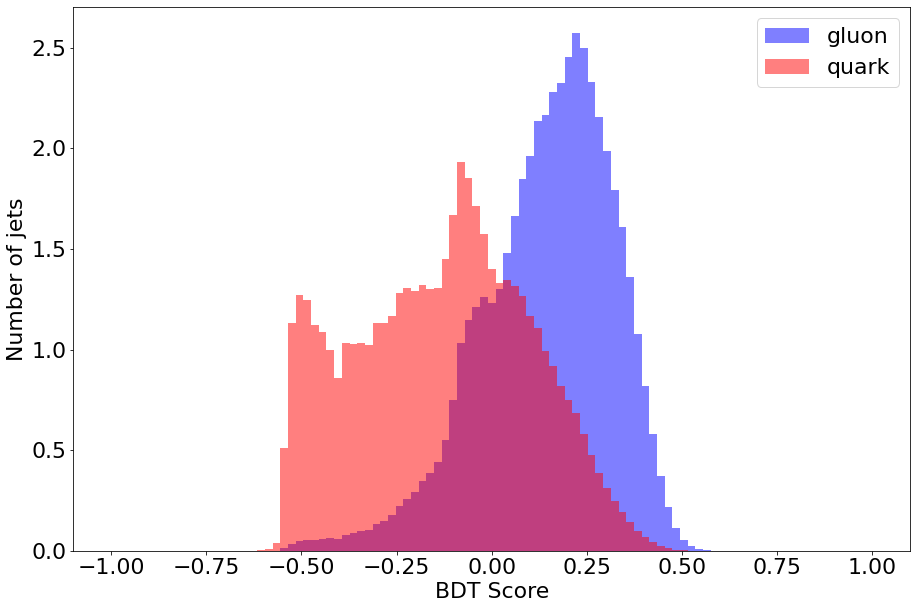

In [34]:
for i in range(0,6):
    print(f"Drawing {branch_names[4+i]}")
    draw_distribution_signal_bkg(variable_gluon = gluon[:,i], variable_quark=quark[:,i], 
                                 weight_gluon=gluon[:,-1], weight_quark=quark[:,-1],
                                 range=user_range[i], xlabel=user_xlabel[i], scale=user_scale[i],
                                 fig_name=user_filename[i], density = True, save=False)

### Variables Without Normalization

Drawing jet_pt


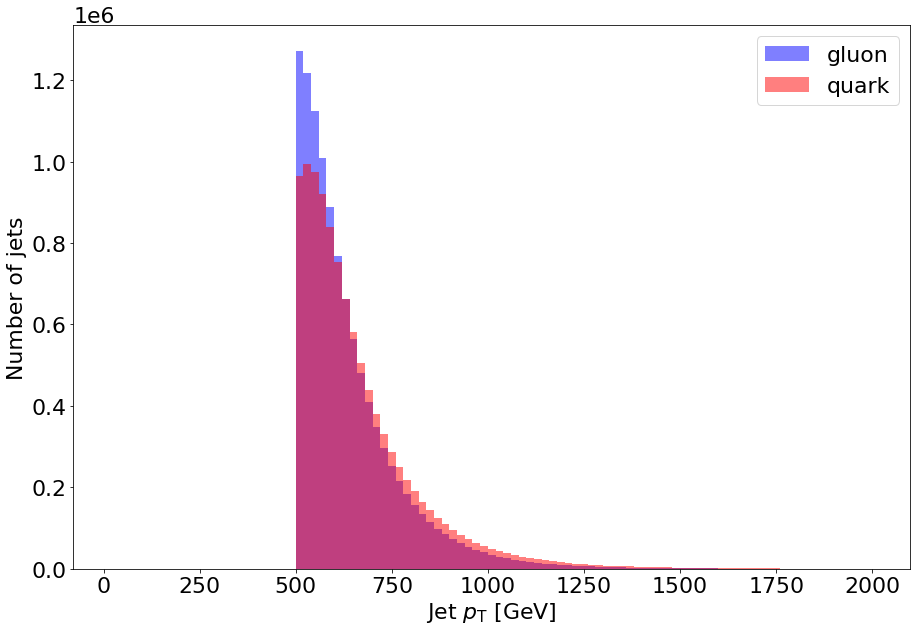

Drawing jet_eta


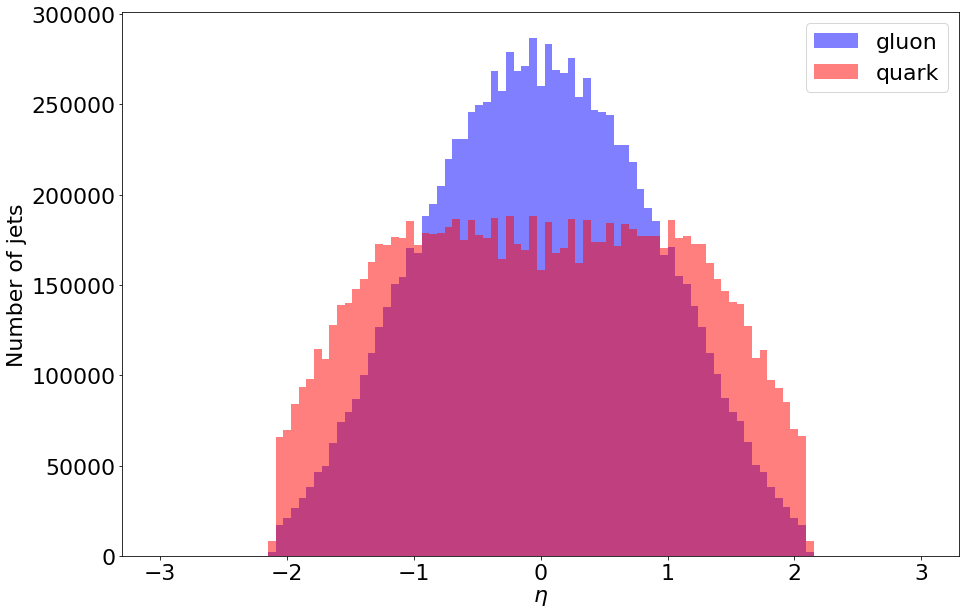

Drawing jet_nTracks


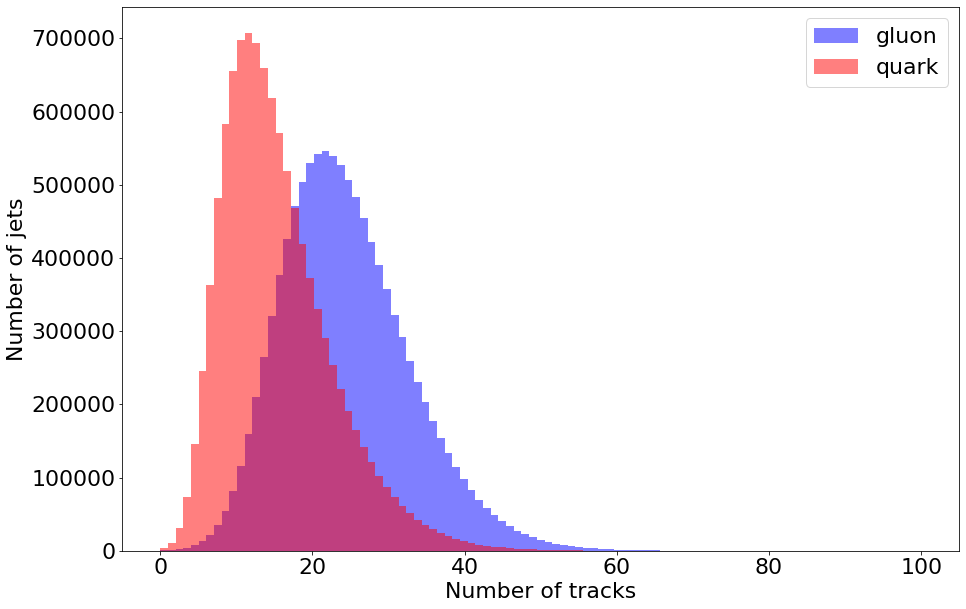

Drawing jet_trackWidth


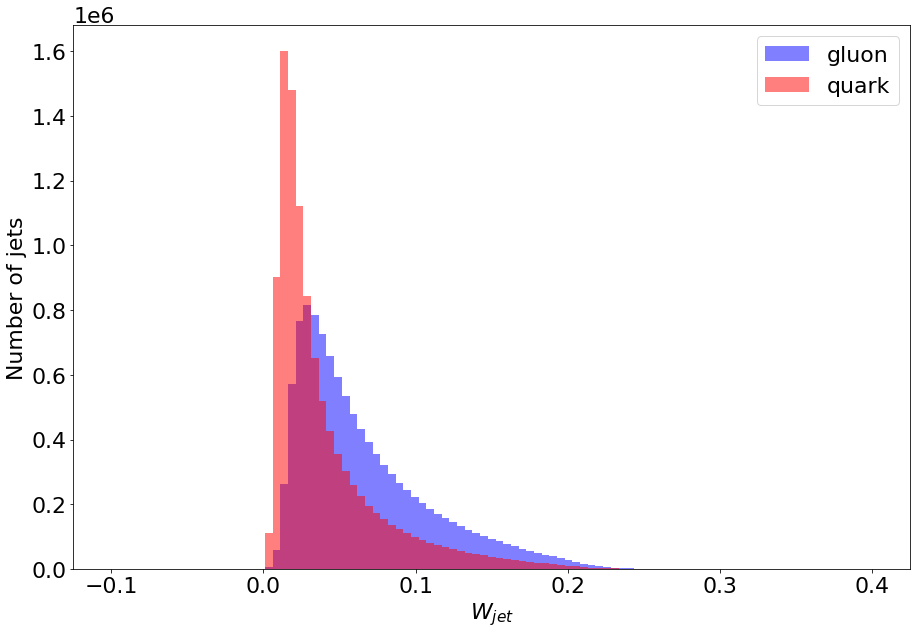

Drawing jet_trackC1


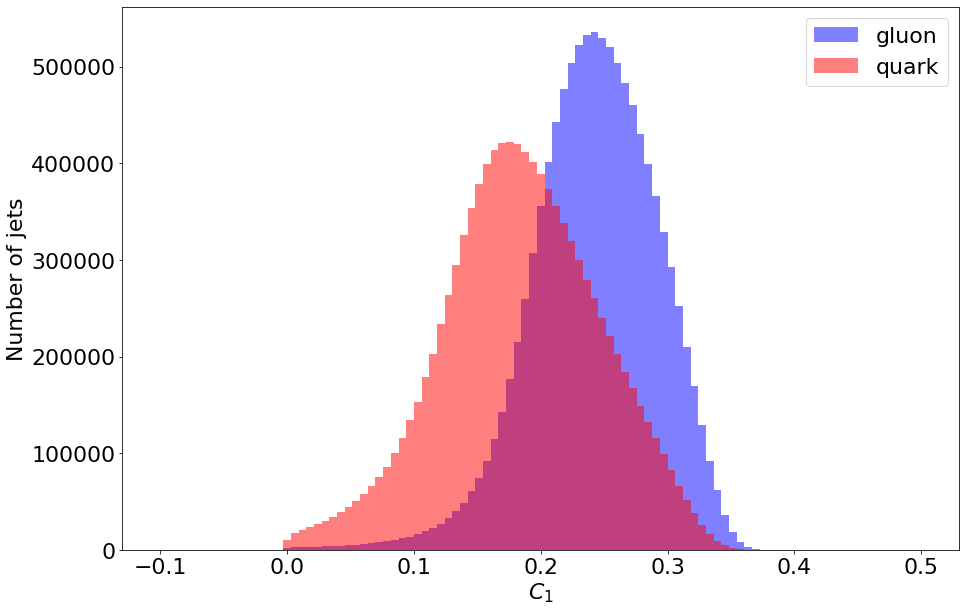

Drawing jet_trackBDT


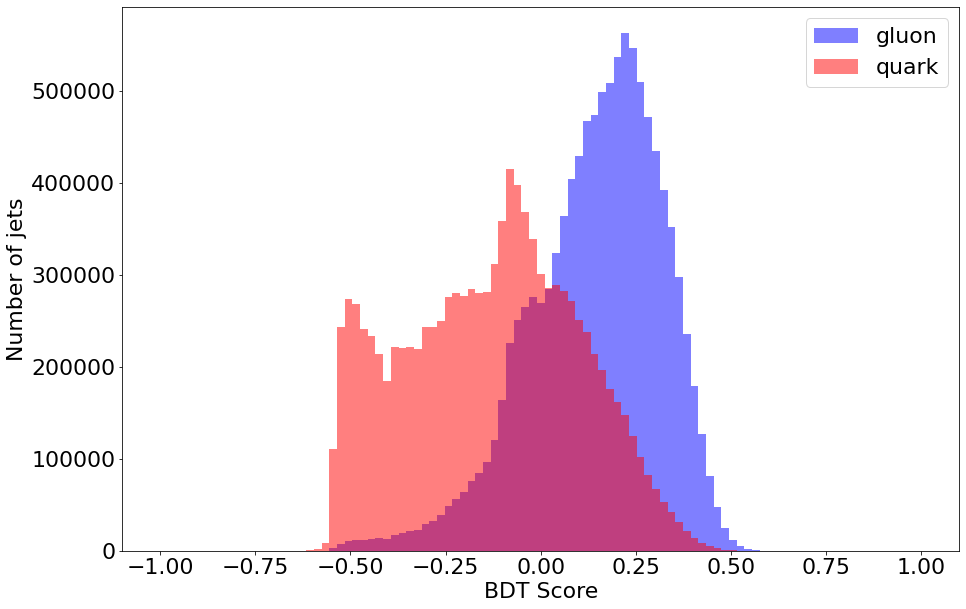

In [35]:
for i in range(0,6):
    print(f"Drawing {branch_names[4+i]}")
    draw_distribution_signal_bkg(variable_gluon = gluon[:,i], variable_quark=quark[:,i], 
                                 weight_gluon=gluon[:,-1], weight_quark=quark[:,-1],
                                 range=user_range[i], xlabel=user_xlabel[i], scale=user_scale[i],
                                 fig_name=user_filename[i], density = False, save=False)

In [38]:
dijets_pt_500_2000 = np.where(np.logical_and( dijets[:,0] >500 * 1e3 , dijets[:,0]< 2000 *1e3))

In [40]:
dijets_pt_500_2000 = dijets[dijets_pt_500_2000]

In [48]:
dijets_pt_500_2000[0]

array([ 6.90616688e+05, -4.25990552e-01,  2.70000000e+01,  1.26707315e-01,
        2.43161410e-01,  4.84484918e-02, -1.00000000e+00,  1.00000000e+00])

In [47]:
dijets_pt_500_2000.shape

(59507988, 8)

In [44]:
np.save("dijets_pt_500_2000.npy", dijets_pt_500_2000)

In [46]:
!ls -alh *.npy

-rw-r--r-- 1 dejavu dejavu 4.4G Aug  2 09:42 dijets_500GeV_cut.npy
-rw-r--r-- 1 dejavu dejavu  18G Aug  1 18:27 dijets_500GeV.npy
-rw-r--r-- 1 dejavu dejavu 4.4G Aug  2 16:49 dijets_500GeV_weightcut.npy
-rw-r--r-- 1 dejavu dejavu 926M Aug  2 16:14 dijets_pt_500_2000_no_weightcut.npy
-rw-r--r-- 1 dejavu dejavu 3.6G Aug  2 16:56 dijets_pt_500_2000.npy
